In [5]:
from vtl.Readfile import Readfile
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sea
import numpy as np
import pandas as pd
import grizli.model
import os
from astropy.table import Table
from astropy.io import fits,ascii
from glob import glob
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
def Get_flux(FILE):
    observ = fits.open(FILE)
    w = np.array(observ[1].data.field('wave'))
    f = np.array(observ[1].data.field('flux')) * 1E-17
    sens = np.array(observ[1].data.field('sensitivity'))
    contam = np.array(observ[1].data.field('contam')) * 1E-17
    e = np.array(observ[1].data.field('error')) * 1E-17
    f -= contam
    f /= sens
    e /= sens
    
    return w, f, e

In [2]:
sp = fits.open('/Volumes/Vince_research/Extractions/Updated_Q_gals/ERSPRIME_39170/ERSPRIME-19-122-G102_39170.1D.fits')

In [36]:
w = np.array(sp[1].data.field('wave'))
f = np.array(sp[1].data.field('flux')) * 1E-17
contam = np.array(sp[1].data.field('contam')) * 1E-17
f -= contam
sens = np.array(sp[1].data.field('sensitivity'))

In [15]:
beam = grizli.model.BeamCutout(fits_file='../beams/icxt19o6q_flt_39170.g102.A.fits')

flat = beam.flat_flam.reshape(beam.beam.sh_beam)
fwv, ffl, e = beam.beam.optimal_extract(np.append(np.zeros([1,flat.shape[0]]),flat.T[:-1],axis=0).T , bin=0)
fwv = fwv[ffl>0]  
ffl = ffl[ffl>0]  

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt

In [18]:
iffl = interp1d(fwv,ffl)(w)

In [21]:
np.save('../data/reshape',[w,sens / (iffl/max(iffl) * max(sens))])

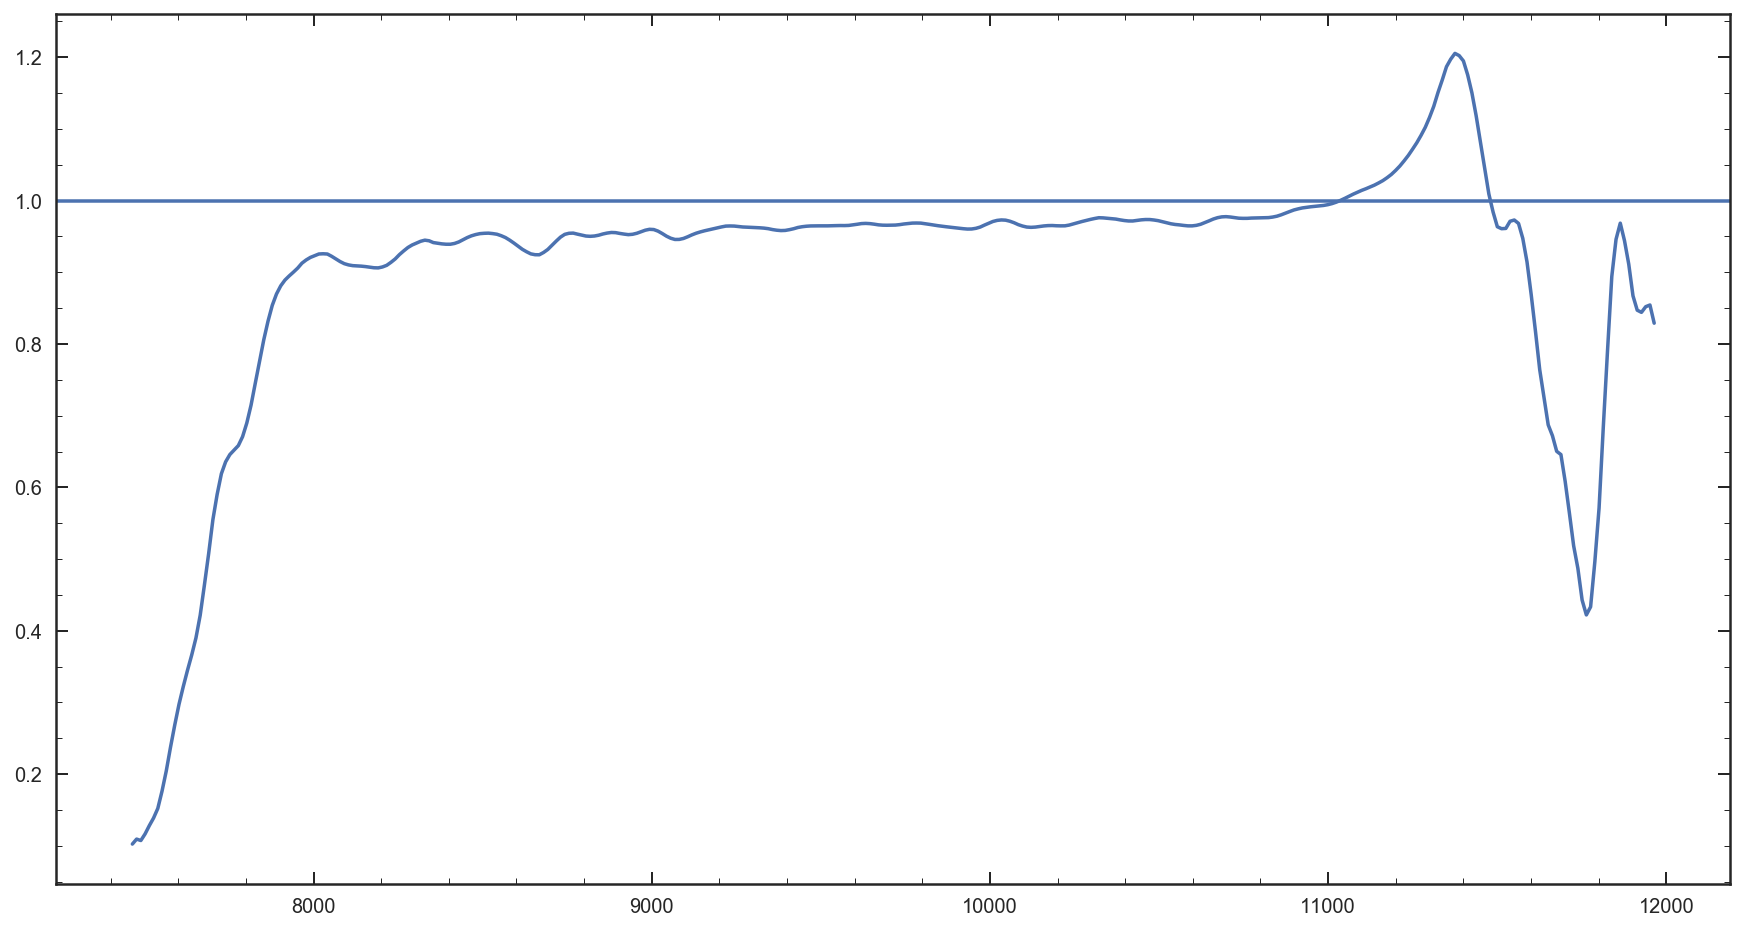

In [42]:
plt.figure(figsize=(15,8))
# plt.plot(w,1.5*f/max(f))
# plt.plot(w,sens/max(sens))
plt.plot(w,sens / (iffl/max(iffl) * max(sens)))
plt.axhline(1)
# plt.ylim(0,1E-17)

In [3]:
s_cand = pd.read_pickle('../data/s_candidates_sup.pkl')
n_cand = pd.read_pickle('../data/n_candidates_sup.pkl')

In [3]:
def Stack_spec(wv, flx, err):
    master_wv = wv[0][10:-10]
        
    #### intialize flux and error grid
    flgrid = np.zeros([len(flx), len(master_wv)])
    errgrid = np.zeros([len(flx), len(master_wv)])

    #### Get wv,fl,er for each spectra
    for i in range(len(flx)):
        flgrid[i] = interp1d(wv[i], flx[i])(master_wv)
        errgrid[i] = interp1d(wv[i], err[i])(master_wv)
    
    
    #### rearrange flux grid and generate weights
    flgrid = np.transpose(flgrid)
    errgrid = np.transpose(errgrid)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid) ## remove inif cause by nans in the error grid
    weigrid[infmask] = 0

    #### Stack spectra
    stack_fl, stack_er = np.zeros([2, len(master_wv)])
    for i in range(len(master_wv)):
        stack_fl[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        stack_er[i] = 1 / np.sqrt(np.sum(weigrid[i]))

    return master_wv, stack_fl, stack_er

In [10]:
idx =48631

ex_listone = glob('/Volumes/Vince_research/Extractions/Updated_Q_gals/*{0}/*'.format(idx))

indv_spec =[]
st_spec = []

for i in range(len(ex_listone)):
    if len(os.path.basename(ex_listone[i]).split('-')) == 2:
        st_spec.append(ex_listone[i])
    else:
        indv_spec.append(ex_listone[i])

In [11]:
indv_spec
# indv_spec = np.append(indv_spec[0:1],indv_spec[3:])

['/Volumes/Vince_research/Extractions/Updated_Q_gals/GS2_48631/GS2-01-189-G102_48631.1D.fits',
 '/Volumes/Vince_research/Extractions/Updated_Q_gals/GS2_48631/GS2-02-189-G102_48631.1D.fits',
 '/Volumes/Vince_research/Extractions/Updated_Q_gals/GS2_48631/GS2-03-169-G102_48631.1D.fits',
 '/Volumes/Vince_research/Extractions/Updated_Q_gals/GS2_48631/GS2-04-169-G102_48631.1D.fits',
 '/Volumes/Vince_research/Extractions/Updated_Q_gals/GS2_48631/GS2-05-209-G102_48631.1D.fits',
 '/Volumes/Vince_research/Extractions/Updated_Q_gals/GS2_48631/GS2-06-209-G102_48631.1D.fits']

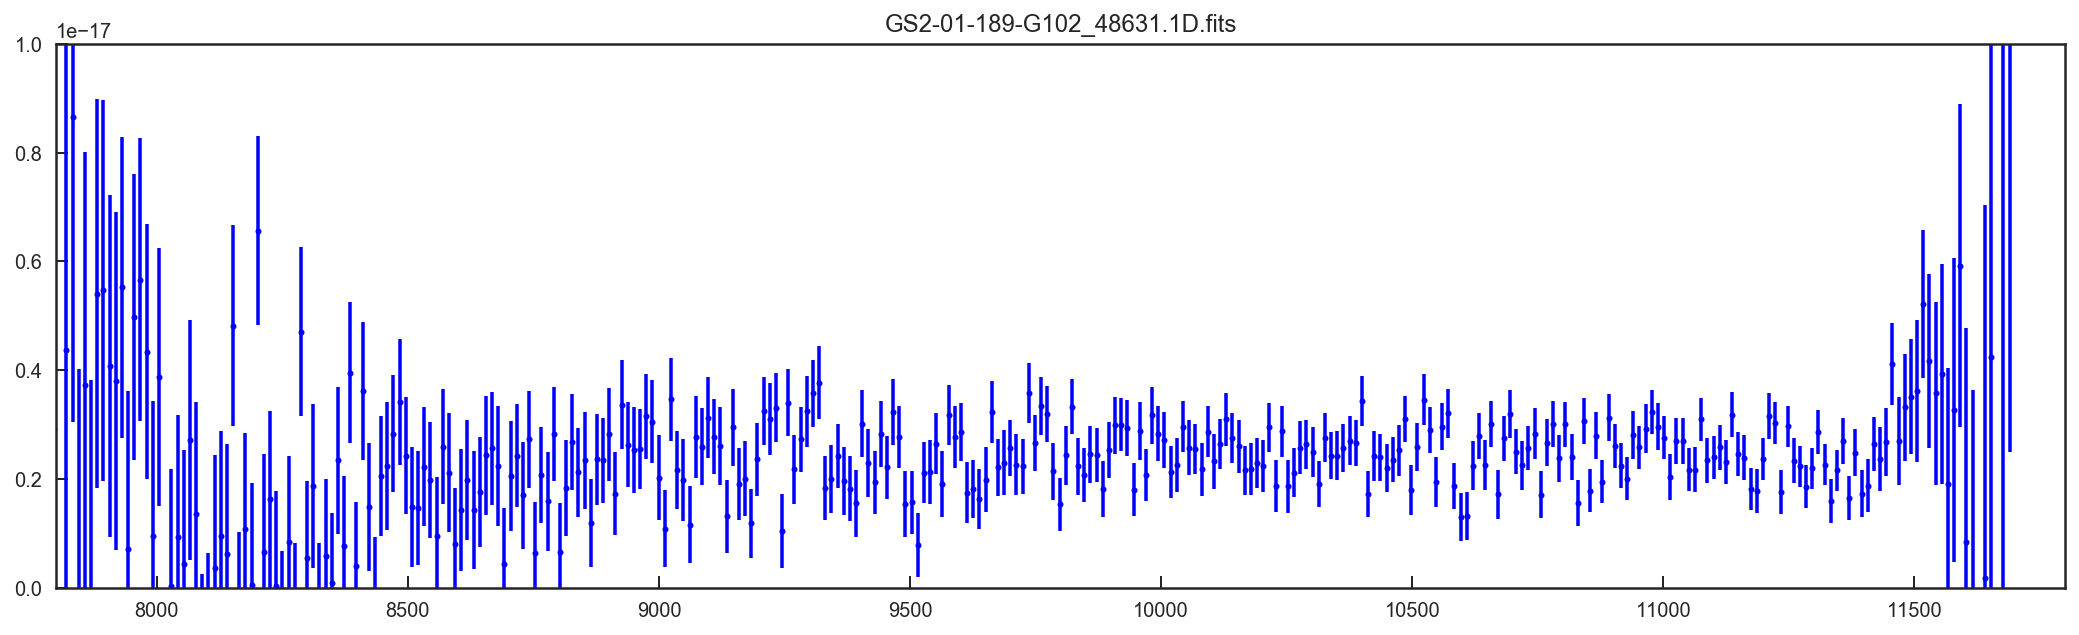

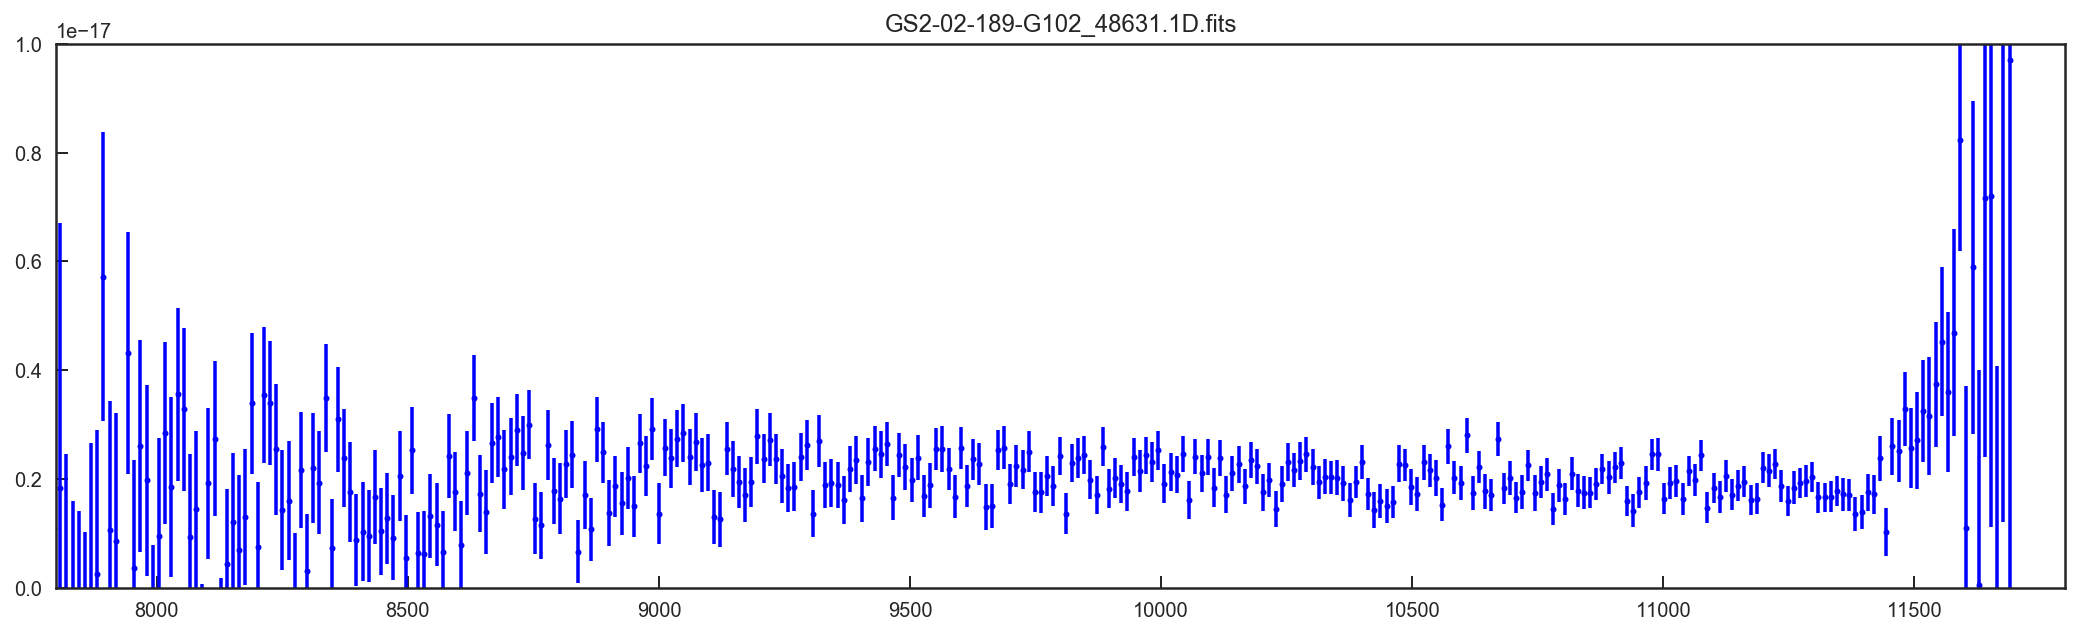

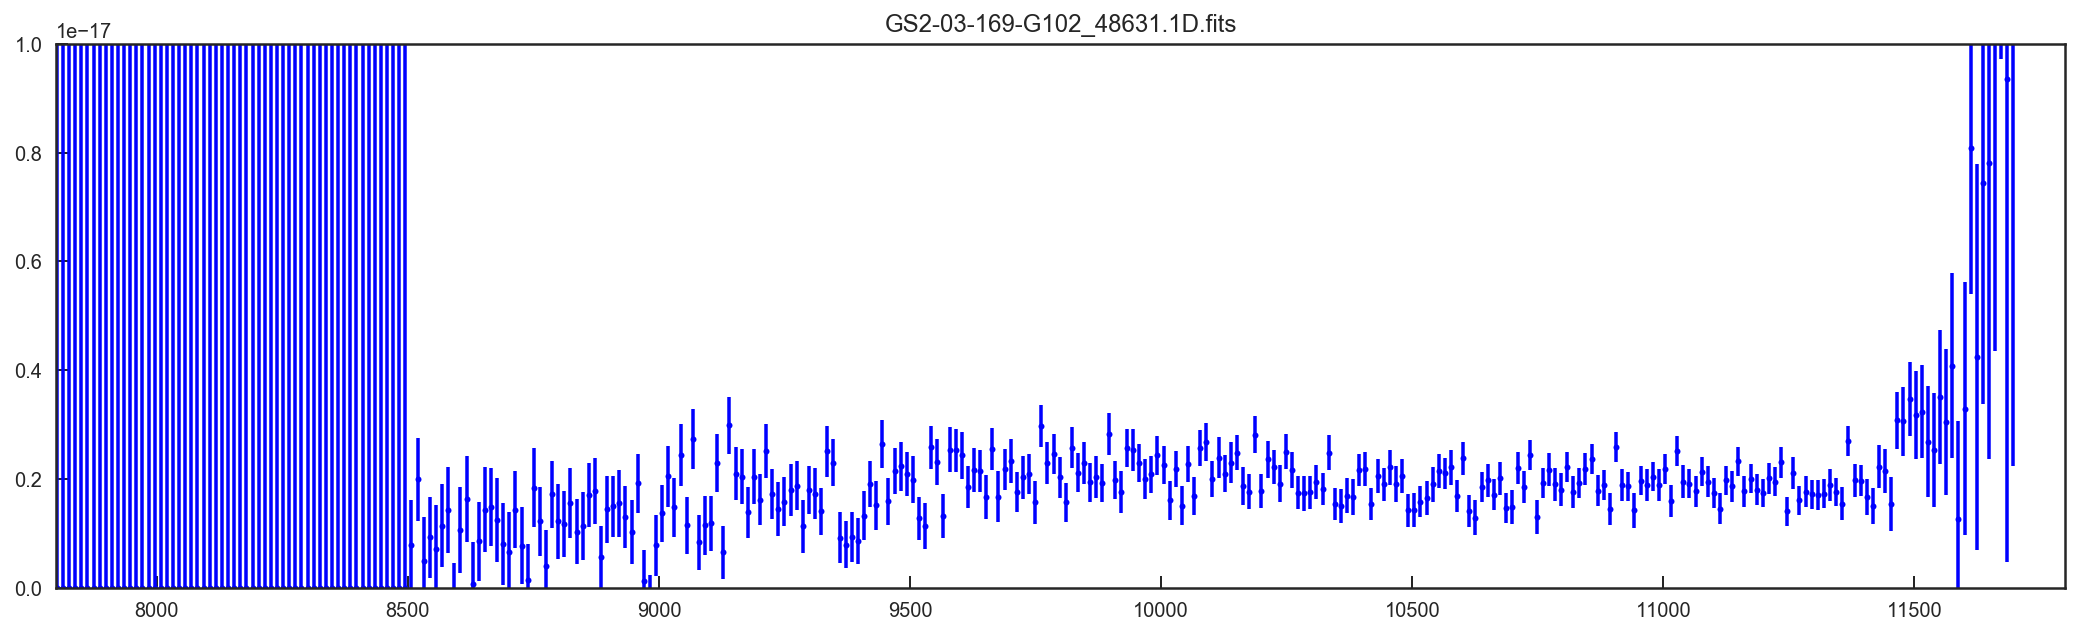

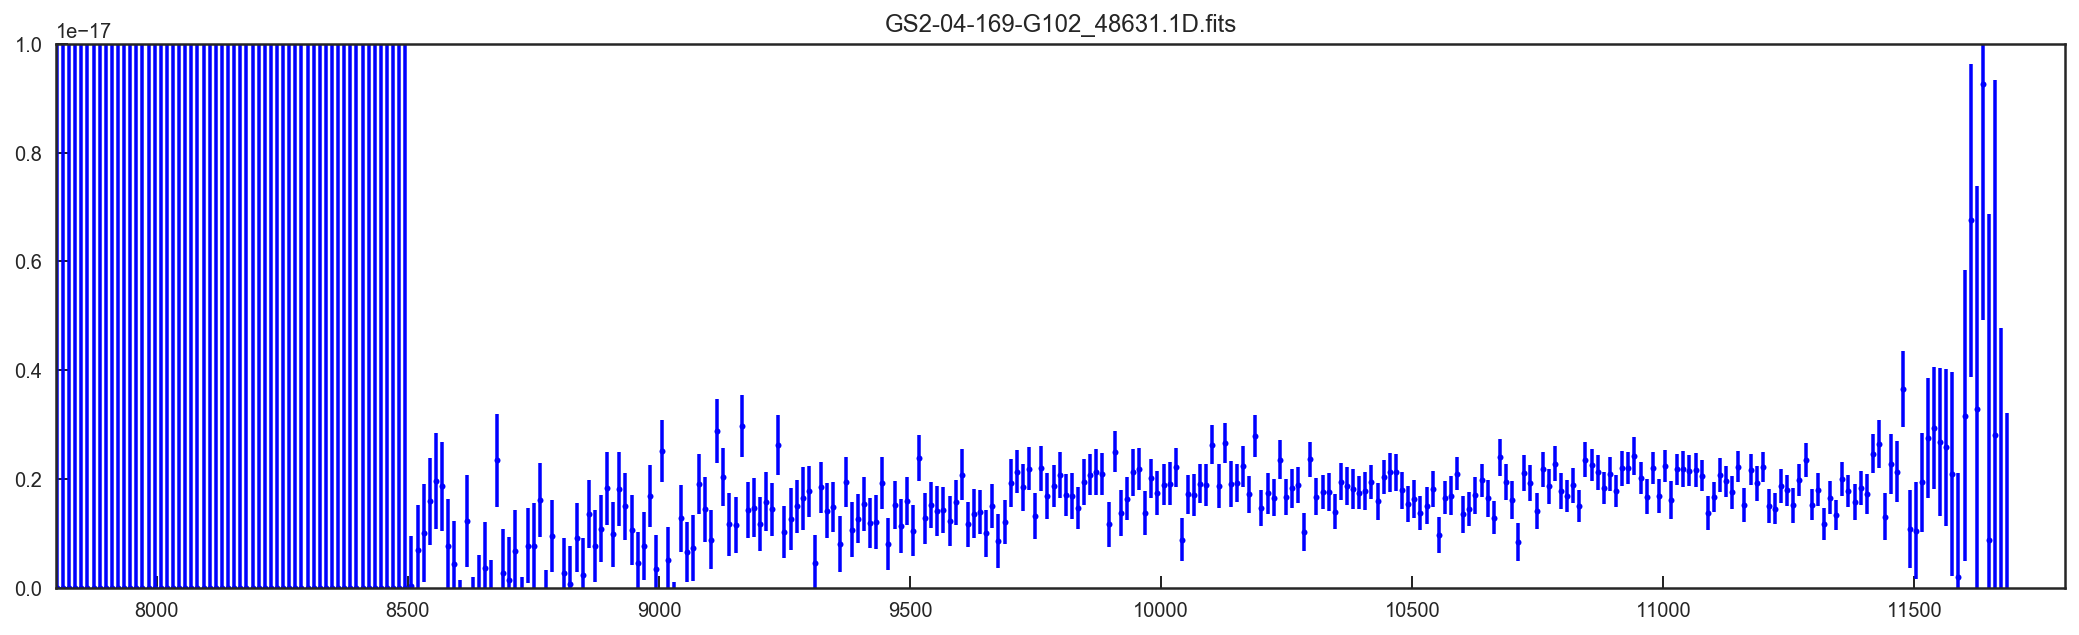

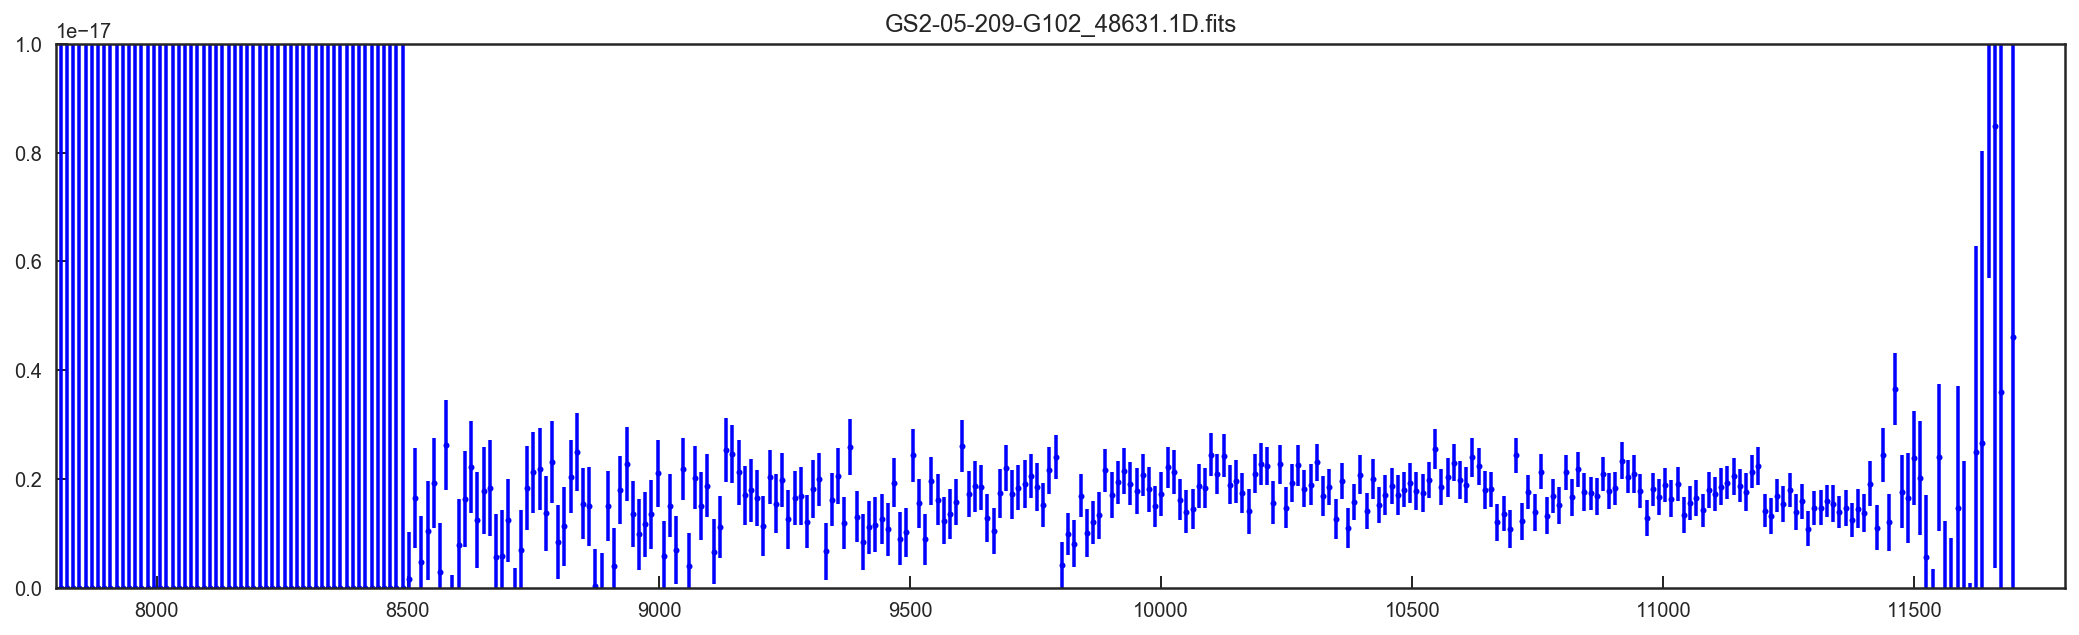

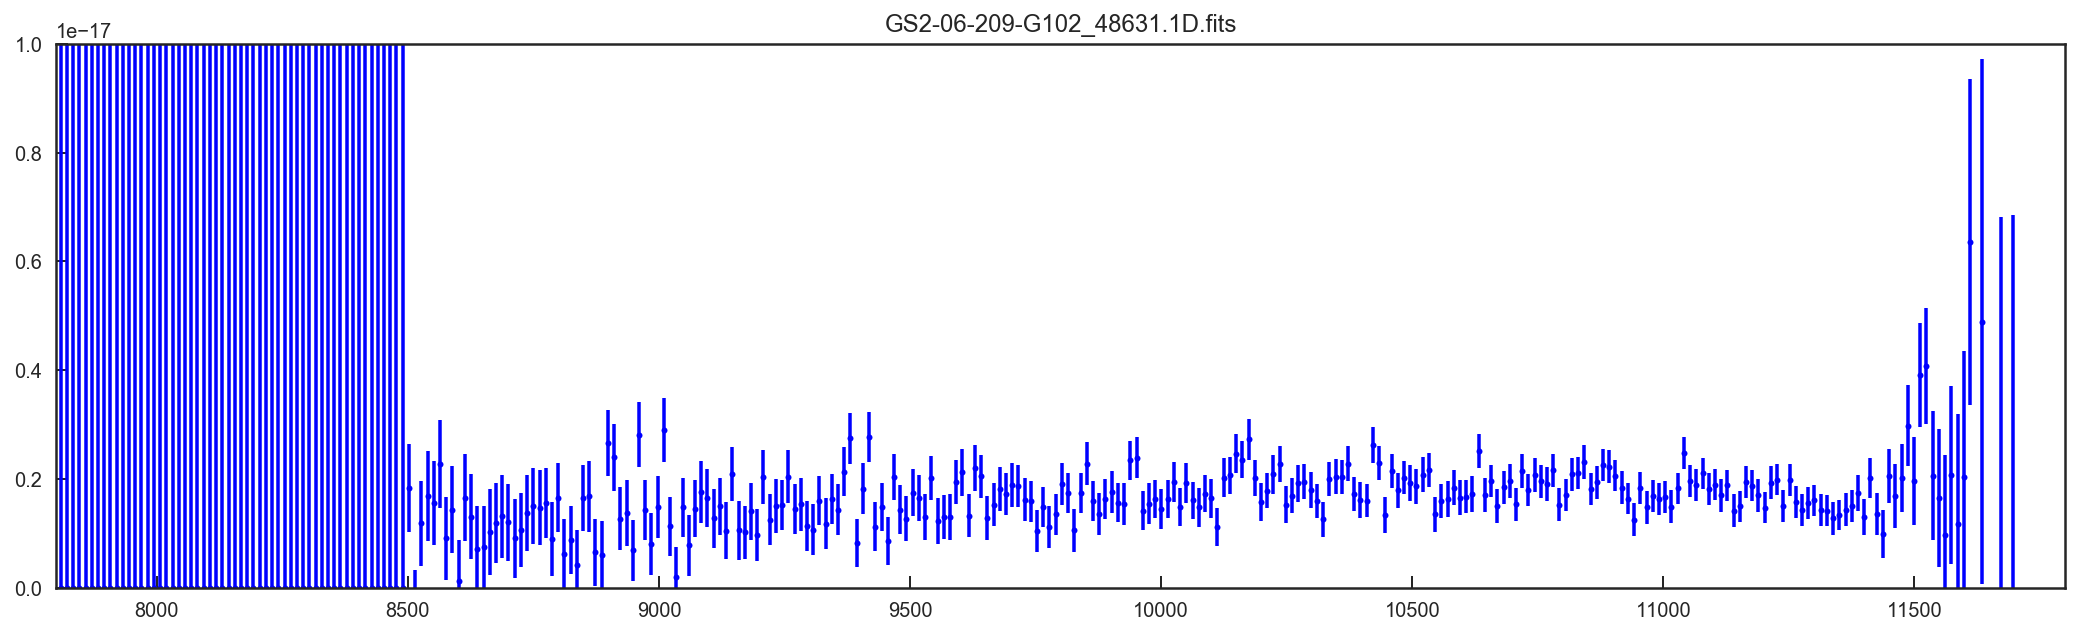

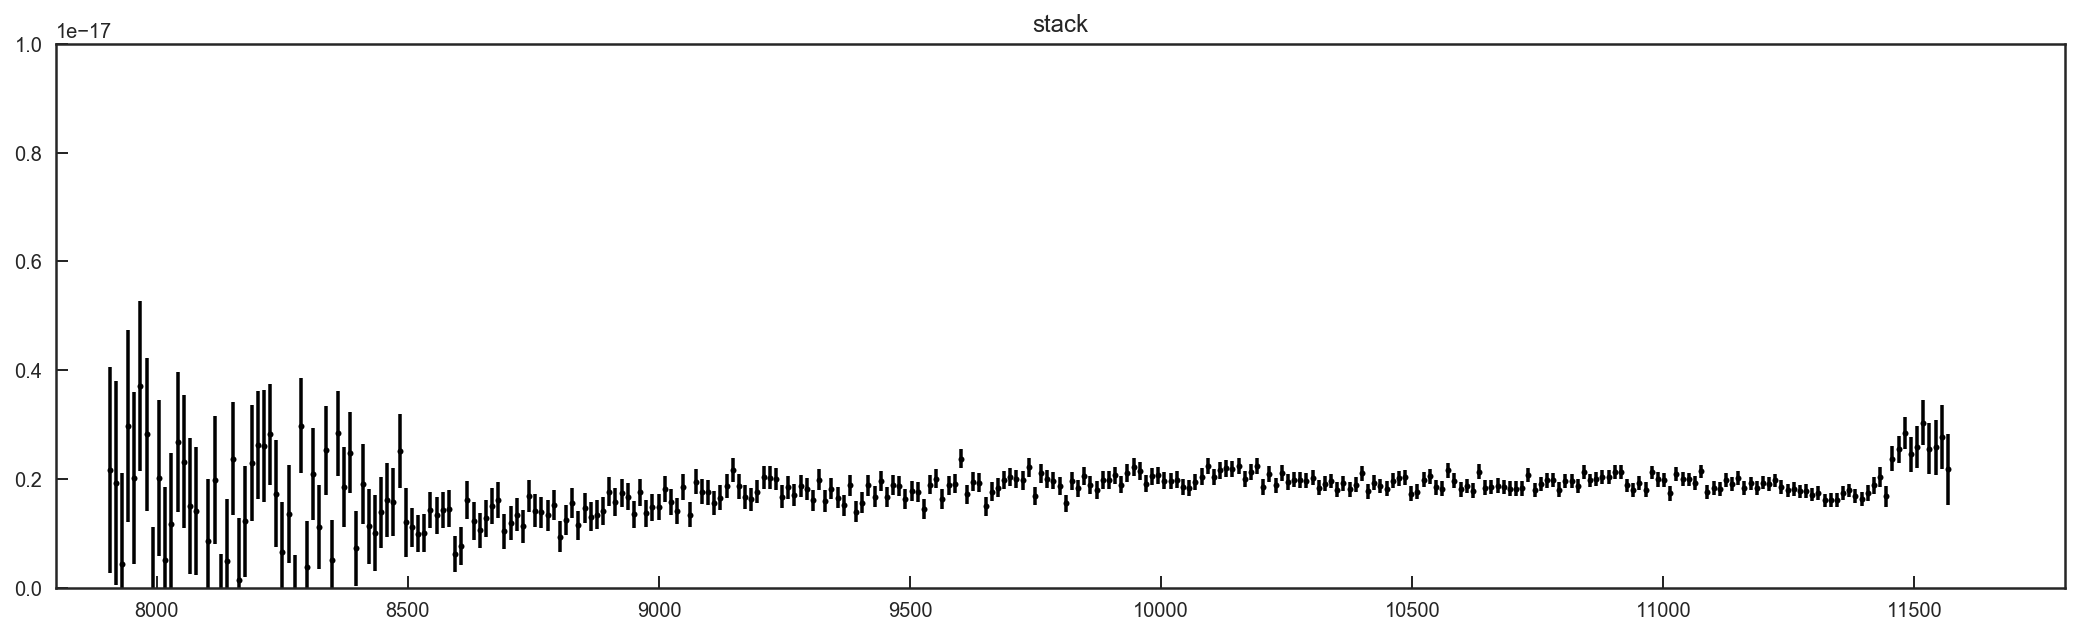

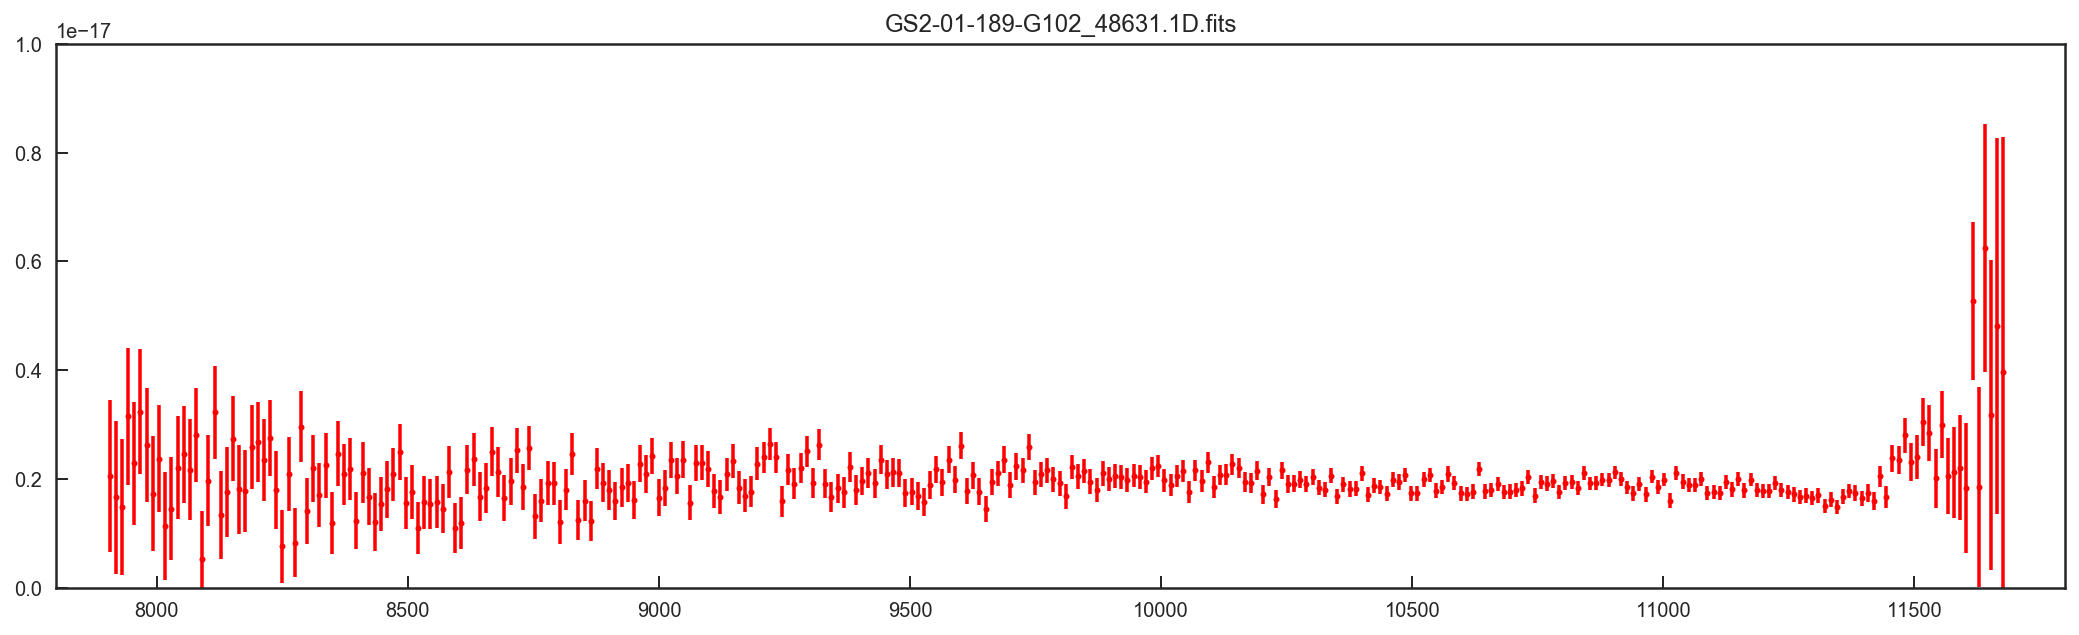

In [14]:
%matplotlib inline
swv,sfl,ser = [[],[],[]]
ylims = [0, 10E-18]
mask =[[],
       [],
       [0,8500],
       [0,8500],
       [0,8500],
       [0,8500],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(len(indv_spec)):
    wv,fl,er = Get_flux(indv_spec[i])
    
    if len(mask[i]) > 0:
        IDM = [U for U in range(len(wv)) if mask[i][0] < wv[U] < mask[i][1]]
        fl[IDM]=0
        er[IDM]=1
    
    IDX = np.array([U for U in range(len(wv)) if 7500 < wv[U] < 11700]).astype(int)

    
    swv.append(wv[IDX])
    sfl.append(fl[IDX])
    ser.append(er[IDX])
    
    plt.figure(figsize=[18,5])
    plt.errorbar(wv[IDX],fl[IDX],er[IDX],linestyle='None', marker='o', markersize=3, color='b')
    plt.ylim(ylims[0],ylims[1])
    plt.xlim(7800,11800)
    plt.title(os.path.basename(indv_spec[i]))
    
stwv, stfl, ster = Stack_spec(swv, sfl, ser)
  
IDX = np.array([U for U in range(len(stwv)) if 7900 < stwv[U] < 11700]).astype(int)

plt.figure(figsize=[18,5])
plt.errorbar(stwv[IDX],stfl[IDX],ster[IDX],linestyle='None', marker='o', markersize=3, color='k')
plt.ylim(ylims[0],ylims[1])
plt.xlim(7800,11800)
plt.title('stack')   
    
for i in range(len(st_spec)):
    wv,fl,er = Get_flux(st_spec[i])
    IDX = np.array([U for U in range(len(wv)) if 7900 < wv[U] < 11700]).astype(int)
    
    plt.figure(figsize=[18,5])
    plt.errorbar(wv[IDX],fl[IDX],er[IDX],linestyle='None', marker='o', markersize=3, color='r')
    plt.ylim(ylims[0],ylims[1])
    plt.xlim(7800,11800)
    plt.title(os.path.basename(indv_spec[i]))   

In [21]:
IDX = np.array([U for U in range(len(stwv)) if 8500 < stwv[U] < 10500]).astype(int)
np.sum(stfl[IDX])/np.sqrt(np.sum(ster[IDX]**2))

22.491122941935476

In [15]:
save_spec = 0
if save_spec == 0:
    np.save('/Volumes/Vince_research/Extractions/Updated_Q_gals/stack_specs/s{0}'.format(idx),
           [stwv, stfl, ster])
else:
    np.save('/Volumes/Vince_research/Extractions/Updated_Q_gals/stack_specs/s{0}'.format(idx),
           [wv, fl, er])

In [137]:
n_cand

,dec,gids,in_out,ra,zphot,zspec,extractions,field
10210,62.192635,10211,in,189.186482,0.8762,-1.0000,in,GDN11
10337,62.194843,10338,in,189.202675,0.9827,1.0133,in,GDN11
10538,62.194459,10539,in,189.202409,0.9905,1.0121,in,GDN11
11396,62.198482,11397,in,189.188911,1.0236,0.9682,in,GDN11
11813,62.200346,11814,in,189.217095,1.6698,-1.0000,in,GDN12
12172,62.201896,12173,in,189.022674,1.4166,-1.0000,in,GDN6
12738,62.204662,12739,in,189.254053,1.1157,-1.0000,in,GDN12
12792,62.205604,12793,in,189.236022,0.9324,0.9542,in,GDN12
13116,62.206599,13117,in,189.260877,1.6337,-1.0000,in,GDN12
13717,62.209512,13718,in,189.229293,1.2491,-1.0000,in,GDN12


# need to add 21427